In [2]:
from utils import load_test_images, load_train_images
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers, Sequential
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Load reshaped test and training images with training images multi-hot encoded
test_imgs = load_test_images()
train_imgs, labels = load_train_images()

img285.jpg doesnt exist
img288.jpg doesnt exist
img286.jpg doesnt exist
img172.jpg doesnt exist
img244.jpg doesnt exist
img287.jpg doesnt exist


In [4]:
test_imgs.shape, train_imgs.shape

((86, 300, 300, 3), (201, 300, 300, 3))

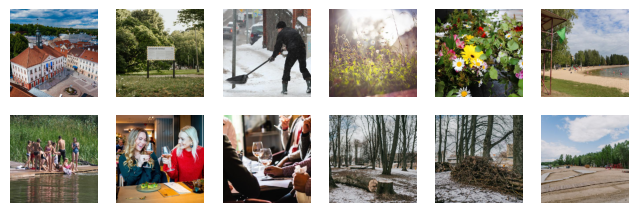

In [15]:
plt.rcParams['figure.figsize'] = (8.0, 8.0) 
for i in range(0,12):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(test_imgs[i])
    plt.axis("off")

In [14]:
# ResNet50

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(300,300,3),
                   pooling='avg',
                   classes=92,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))

# Use sigmoid because multi-label classification. Softmax would be used with multi-class
resnet_model.add(Dense(92, kernel_initializer= tf.keras.initializers.GlorotUniform(seed=111), activation='sigmoid'))
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 92)                47196     
                                                                 
Total params: 24,683,996
Trainable params: 1,096,284
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
# BinaryCrossentropy: cross-entropy loss between true labels and predicted labels
# BinaryAccuracy: how often predictions match binary labels
#                 (because there are a lot of zeros in the label vectors, this is too optimistik)
# Recall: ratio of how many of the actual labels were predicted
# Precision: the ratio of how much of the predicted is correct
# F1Score: harmonic mean of precision and recall
# HammingLoss: the fraction of the wrong labels to the total number of labels

resnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision(),
                      tfa.metrics.HammingLoss(mode='multilabel'),
                      tfa.metrics.F1Score(num_classes=92)], 
                      optimizer=optimizers.Adam(learning_rate=0.001))


# Model without image augmentation
history = resnet_model.fit(train_imgs, np.array(labels), batch_size=10, epochs=15, validation_split=0.2)

# Save model
resnet_model.save('Kea_resnet_01.hdf5')

Epoch 1/15
16/16 [==============================] - 105s 6s/step - loss: 0.2597 - binary_accuracy: 0.9145 - recall_1: 0.0420 - precision_1: 0.0432 - hamming_loss: 0.0495 - f1_score: 0.0098 - val_loss: 0.1990 - val_binary_accuracy: 0.9549 - val_recall_1: 0.1084 - val_precision_1: 0.4500 - val_hamming_loss: 0.0453 - val_f1_score: 0.0066
Epoch 2/15
16/16 [==============================] - 87s 5s/step - loss: 0.1764 - binary_accuracy: 0.9529 - recall_1: 0.0405 - precision_1: 0.3333 - hamming_loss: 0.0482 - f1_score: 0.0088 - val_loss: 0.1769 - val_binary_accuracy: 0.9560 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_hamming_loss: 0.0453 - val_f1_score: 0.0066
Epoch 3/15
16/16 [==============================] - 80s 5s/step - loss: 0.1652 - binary_accuracy: 0.9541 - recall_1: 0.0450 - precision_1: 0.4286 - hamming_loss: 0.0470 - f1_score: 0.0098 - val_loss: 0.1684 - val_binary_accuracy: 0.9560 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_hamming_loss: 0.048

Text(0.5, 1.0, 'Hamming loss: the fraction of the wrong labels to the total number of labels')

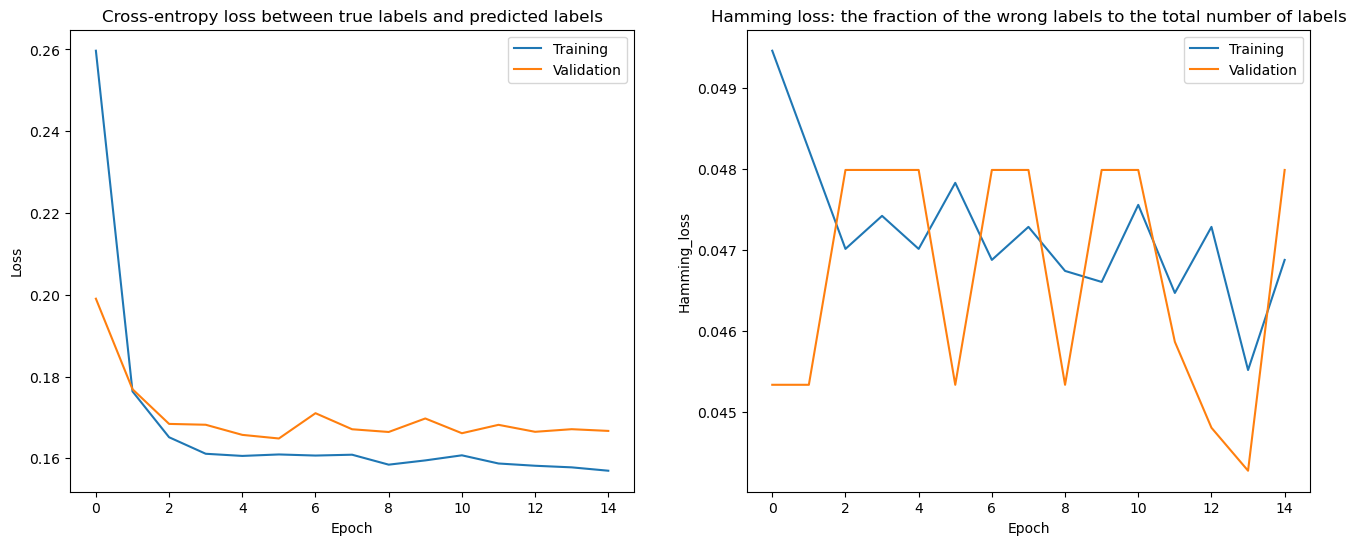

In [18]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Cross-entropy loss between true labels and predicted labels')

plt.subplot(1, 2, 2)
plt.plot(history.history['hamming_loss'])
plt.plot(history.history['val_hamming_loss'])
plt.xlabel('Epoch')
plt.ylabel('Hamming_loss')
plt.legend(['Training', 'Validation'])
plt.title('Hamming loss: the fraction of the wrong labels to the total number of labels')

Text(0.5, 1.0, 'Recall: ratio of how many of the actual labels were predicted')

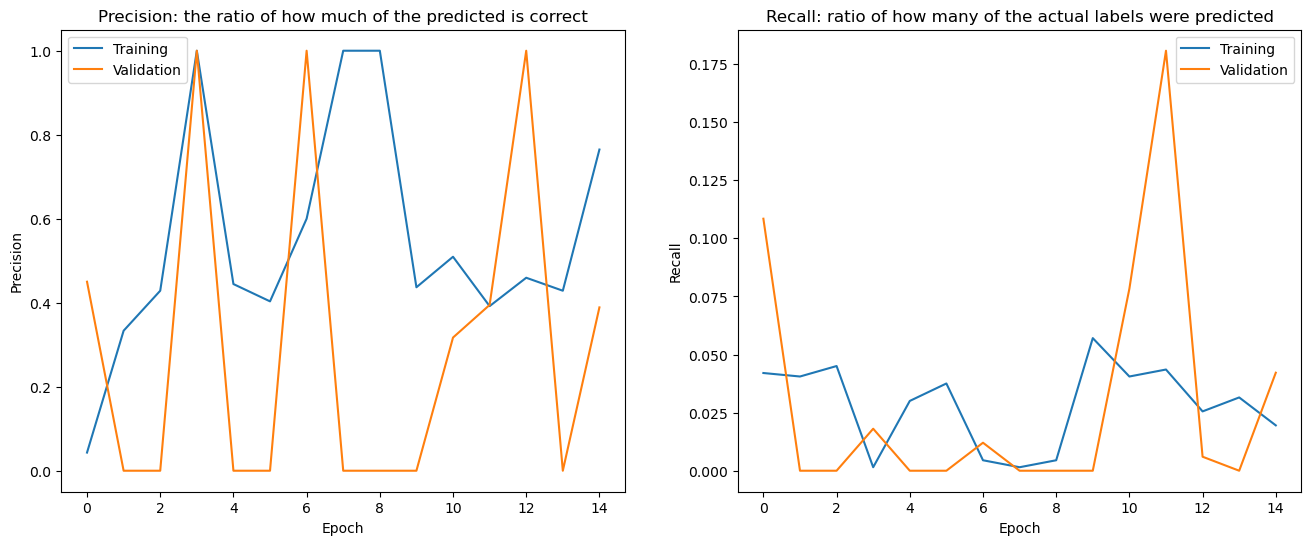

In [20]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.title('Precision: the ratio of how much of the predicted is correct')

plt.subplot(1, 2, 2)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training', 'Validation'])
plt.title('Recall: ratio of how many of the actual labels were predicted')

Text(0.5, 1.0, 'f1_score: harmonic mean of precision and recall')

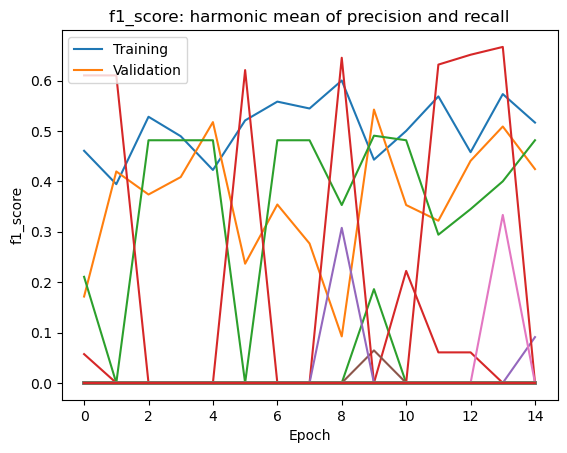

In [21]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend(['Training', 'Validation'])
plt.title('f1_score: harmonic mean of precision and recall')

In [ ]:
# Model evaluation
# TO-DO